### Import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
import ecco_v4_py as ecco
warnings.filterwarnings('ignore')

import warnings
import cmocean
from dask.distributed import Client

from xmitgcm import llcreader

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

### Load the grid

In [2]:
# define basin we want - here 6 is for Barents
# we can look directly at the layers output if we want to:
#  cd /scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

(50,) (50, 1350, 270)
hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [3]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(12,13,1)
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

In [4]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
AB_gS = 0

### Load the UVELMASS and VVELMASS as faces in the dataset

In [38]:
# horizontal convergence terms for U and V mass
meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m/s
VVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m/s

UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)

### Get the vector faces manually and add to dataset

In [39]:
UVELMASSf1 = UVELMASS[:,nfx[3]:nfy[0],0:nx]
UVELMASSf3 = UVELMASS[:,nfy[0]:nfy[0]+nfy[2],0:nx]
VVELMASSf1 = VVELMASS[:,nfx[3]:nfy[0],0:nx]
VVELMASSf3 = VVELMASS[:,nfy[0]:nfy[0]+nfy[2],0:nx]

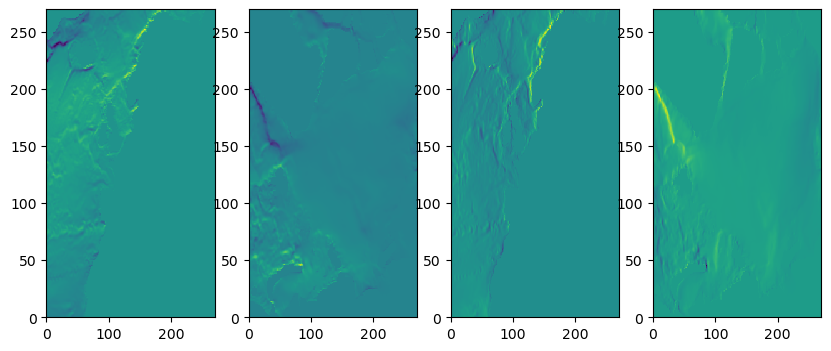

In [40]:
fig = plt.figure()

ax = plt.subplot(141)
ax.pcolormesh(UVELMASSf1[0])
ax = plt.subplot(142)
ax.pcolormesh(UVELMASSf3[0])

ax = plt.subplot(143)
ax.pcolormesh(VVELMASSf1[0])
ax = plt.subplot(144)
ax.pcolormesh(VVELMASSf3[0])

In [44]:
# stack the faces so we have two
a = (np.full((50,270,270),0))
UVELMASS = np.stack((a,UVELMASSf1, UVELMASSf3,a,a,a), axis=1)
UVELMASS = UVELMASS[np.newaxis,:,:,:,:]
print(UVELMASS.shape)


VVELMASS = np.stack((a,VVELMASSf1, VVELMASSf3,a,a,a), axis=1)
VVELMASS = VVELMASS[np.newaxis,:,:,:,:]
print(VVELMASS.shape)

(1, 50, 6, 270, 270)
(1, 50, 6, 270, 270)


In [49]:
# add to dataset
dimsu = ("time","k","tile","j","i_g")
dimsv = ("time","k","tile","j_g","i")

coordsu = {"time" : np.array(datetimes[1]).reshape(1),
          "k" : np.arange(0,50,1),
          "tile" : np.arange(0,6,1),
          "j" : np.arange(0,270,1),
          "i_g" : np.arange(0,270,1)}
coordsv = {"time" : np.array(datetimes[1]).reshape(1),
          "k" : np.arange(0,50,1),
          "tile" : np.arange(0,6,1),
          "j_g" : np.arange(0,270,1),
          "i" : np.arange(0,270,1)}

# add mskBasin and wetmask to the xarray for the dataset
UVELMASS = xr.DataArray(data = UVELMASS,
                    dims = dimsu,
                    coords = coordsu)

VVELMASS = xr.DataArray(data = VVELMASS,
                    dims = dimsv,
                    coords = coordsv)
ds = xr.Dataset()
ds['UVELMASS'] = UVELMASS
ds['VVELMASS'] = VVELMASS
ds

<xarray.Dataset>
Dimensions:   (time: 1, k: 50, tile: 6, j: 270, i_g: 270, j_g: 270, i: 270)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * tile      (tile) int64 0 1 2 3 4 5
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i         (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
Data variables:
    UVELMASS  (time, k, tile, j, i_g) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VVELMASS  (time, k, tile, j_g, i) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [31]:
aste = llcreader.SverdrupASTE270Model()
ds1 = aste.get_dataset()
ds1 = ds1.sel(time='2015-01')
ds1 = ds1.rename({'face':'tile'})
cds = ds1.coords.to_dataset().reset_coords()
ds1 = ds1.reset_coords(drop=True)
grid = ecco.get_llc_grid(cds,domain='aste')

In [50]:
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'],
                                                ds['VVELMASS'],
                                                coords=cds,
                                                grid=grid)

(1, 50, 1, 270, 270)


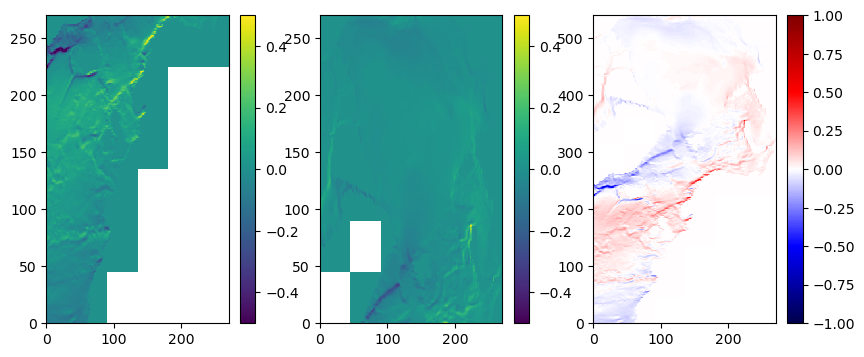

In [64]:
# try to plot
tile1 = uvel.where(uvel.tile == 1, drop=True)
tile2 = uvel.where(uvel.tile == 2, drop=True)
print(tile1.shape)


fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tile1.values[0,0,0,:,:],vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(tile2.values[0,0,0,:,:],3),vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(np.vstack((tile1.values[0,0,0,:,:],np.rot90(tile2.values[0,0,0,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)
a = np.vstack((tile1.values[0,0,0,:,:],np.rot90(tile2.values[0,0,0,:,:],3)))

(1, 50, 1, 270, 270)


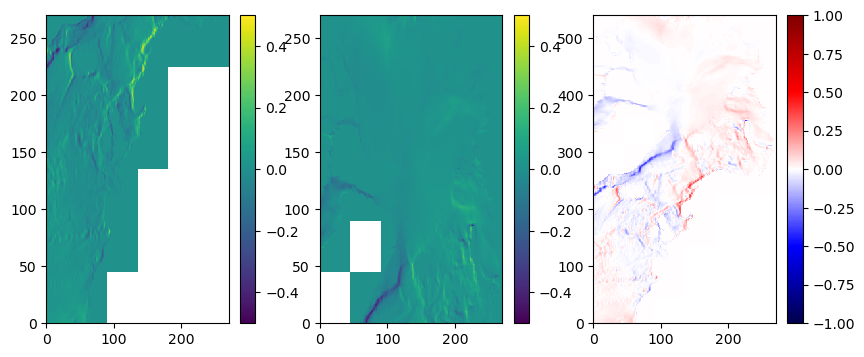

In [65]:
# try to plot
tile1 = vvel.where(vvel.tile == 1, drop=True)
tile2 = vvel.where(vvel.tile == 2, drop=True)
print(tile1.shape)


fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tile1.values[0,0,0,:,:],vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(tile2.values[0,0,0,:,:],3),vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(np.vstack((tile1.values[0,0,0,:,:],np.rot90(tile2.values[0,0,0,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)
b = np.vstack((tile1.values[0,0,0,:,:],np.rot90(tile2.values[0,0,0,:,:],3)))

### Great, now we have uvel and vvel for the faces, can we do convergence?

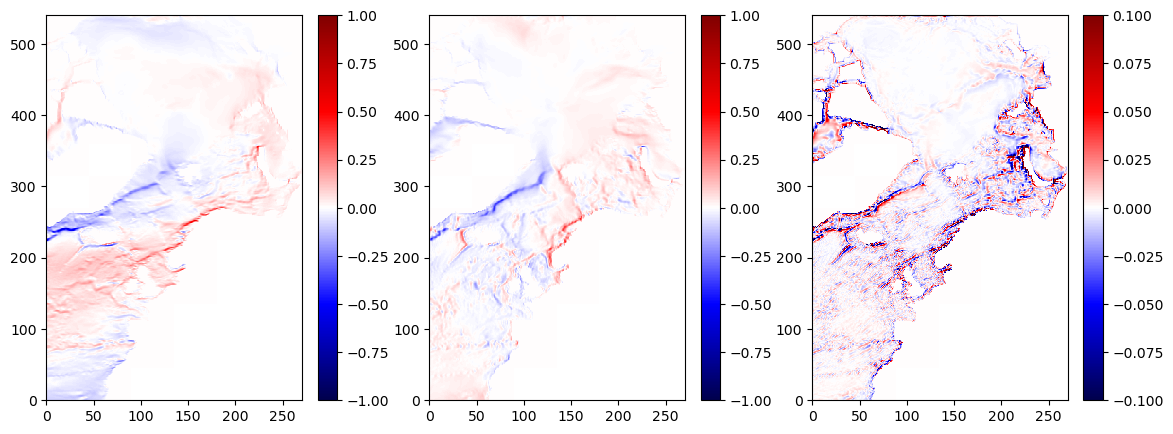

In [68]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot(131)
cb = ax.pcolormesh(a,cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(b,cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(calc_UV_conv_1face(a,b)[0],cmap = 'seismic',vmin=-.1,vmax=.1)
plt.colorbar(cb)

In [69]:
# calc zconv
# vertical convergence terms for mass
meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
oceFWflx,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])
# Net freshwater flux from atmosphere & land (+=down)
SIatmFW,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])

# read WVELMASS
meta_budg3d_zflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_zflux_set2['fldList'])
varnames = np.array(['WVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# Vertical Mass-Weighted Comp of Velocity
WVELMASS,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])

oceFWflx = oceFWflx.reshape(ny,nx)  # * wetmask[0,:,:] * mymsk                       # kg/m^2/s
# SIatmFW = SIatmFW.reshape(ny,nx) * wetmask[0,:,:] * mymsk                         # kg/m^2/s
WVELMASS = WVELMASS.reshape(nz,ny,nx)

In [90]:
# Perform calculations for zconv
budgO_zconv = oceFWflx

if not myparms["useRFWF"]:
    budgO_zconv = 0 * budgO_zconv

trWtop = -WVELMASS * myparms["rhoconst"]
print(trWtop.shape)

# indexing seems fishy here - rewrite
if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO_fluxes_trWtop = trWtop * RAC3
budgO_fluxes_trWbot = trWbot * RAC3
budgO_fluxes_zconv = budgO_fluxes_trWtop - budgO_fluxes_trWbot

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO_zconv += np.sum(trWtop - trWbot, axis=0)

budgO_zconv = RAC * budgO_zconv
# ds["budgO_fluxes_zconv_mass"] = xr.DataArray(data = budgO_fluxes_zconv, dims = dims3d_avg,coords = coords3d_avg)

(50, 1350, 270)


In [91]:
budgO_fluxes_zconvf1 = budgO_fluxes_zconv[:,nfx[3]:nfy[0],0:nx]
budgO_fluxes_zconvf3 = budgO_fluxes_zconv[:,nfy[0]:nfy[0]+nfy[2],0:nx]

budgO_fluxes_zconv_test = np.vstack((budgO_fluxes_zconvf1[0,:,:],np.rot90(budgO_fluxes_zconvf3[0,:,:],3)))

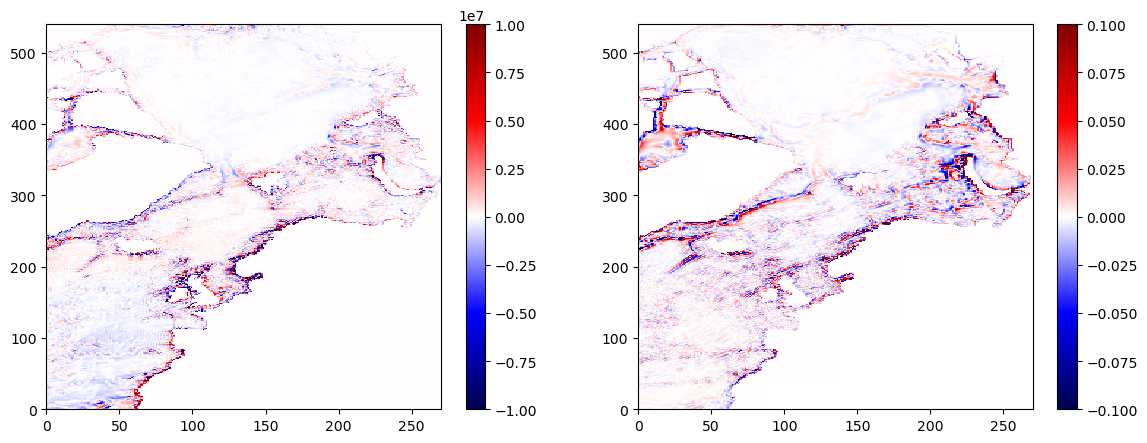

In [94]:
fig = plt.figure(figsize=(14,5))

ax = plt.subplot(121)
norm = TwoSlopeNorm(vmin=-1e7,vcenter=0,vmax=1e7)
cb = ax.pcolormesh(budgO_fluxes_zconv_test,cmap = 'seismic',norm=norm)
plt.colorbar(cb)

ax = plt.subplot(122)
cb = ax.pcolormesh(calc_UV_conv_1face(a,b)[0],cmap = 'seismic',vmin=-.1,vmax=.1)
plt.colorbar(cb)